### **Vấn đề  1: Nếu có 1 file .csv.gz 10gb (nếu giải nén thì ra được 50gb các file .csv), nếu từ .csv.gz convert sang parquet thì có khác gì từ .csv.gz => giải nén => rồi convert sang parquet không, kích thước nó có khác nhau không? So sánh 2 phương pháp.**

So sánh 2 phương pháp sử lý file .csv.gz kích thước lớn:

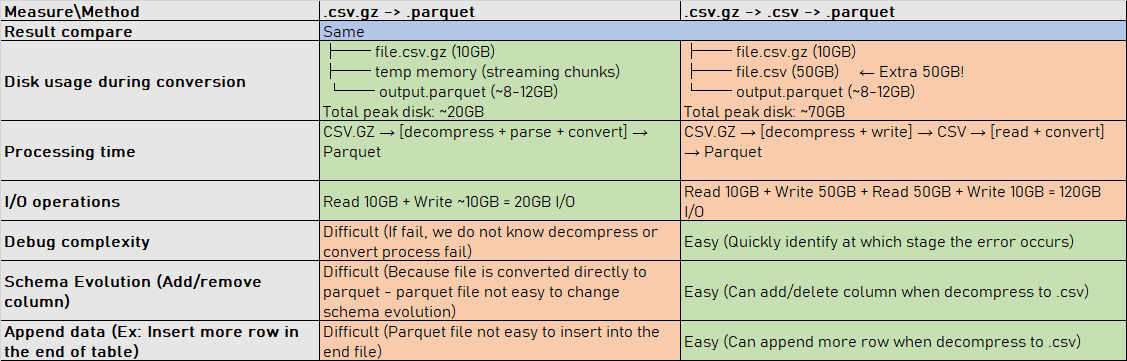

In [ ]:
# ✅ Recommended (Direct)
import polars as pl
import time

start = time.time()
pl.scan_csv('file.csv.gz').sink_parquet('output.parquet')
print(f"Time: {time.time() - start}s")

# ❌ Avoid (Intermediate - trừ khi cần debug)
!gunzip file.csv.gz
pl.scan_csv('file.csv').sink_parquet('output.parquet')
!rm file.csv  # Don't forget cleanup!

### **Vấn đề 2: Bản chất quá trình xử lý sẽ là: 1 file .csv.gz sẽ được tách ra thành từng chunk, từng chunk này sẽ được giải nén và convert thành .parquet lần lượt đúng không?**

Chuẩn rồi, tiến trình cụ thể như sau:

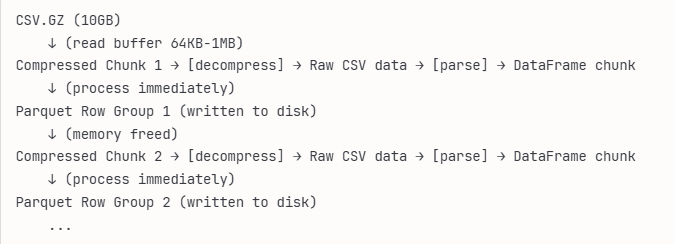

output.parquet

├── Row Group 0 (chunk 1: rows 0-99,999)

├── Row Group 1 (chunk 2: rows 100,000-199,999)  

├── Row Group 2 (chunk 3: rows 200,000-299,999)

└── Metadata (schema, statistics)

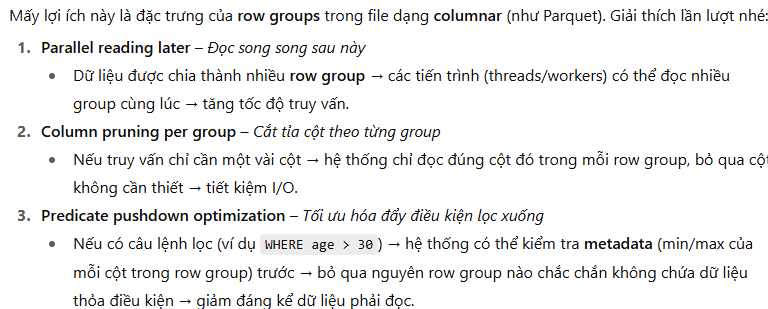

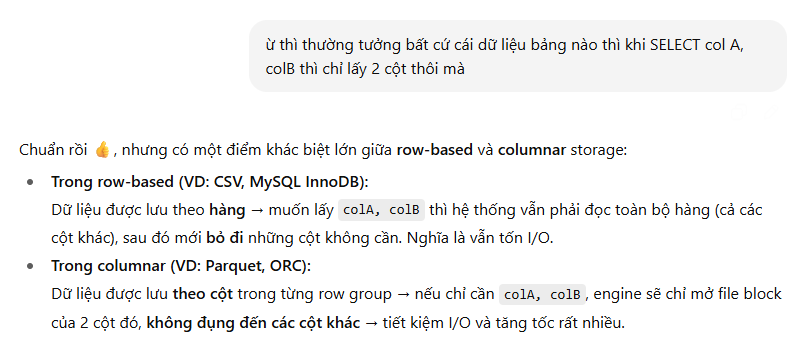

### **Vấn đề 3: Nếu RAM đủ lớn thì có cần chia thành chunk để xử lý không?**

Có, chia thành Chunk có những lợi ích sau:
- Ram kích thước nhỏ vẫn xử lý được file lớn (VD: Ram 16GB vẫn có thể xử lý file .csv.gz 50GB bằng cách chia thành Chunk và xử lý từng Chunk một)
- Tăng tốc độ xử lý, vì khi chia thành Chunk thì có thể xử lý song song nhiều Chunk cùng 1 lúc (tức là vẫn có lợi ích về rút ngắn thời gian xử lý ngay cả khi RAM đủ lớn).
- Tiết kiệm RAM cho các tác vụ khác.
- Parquet output khác biệt (Quan trọng):
   + 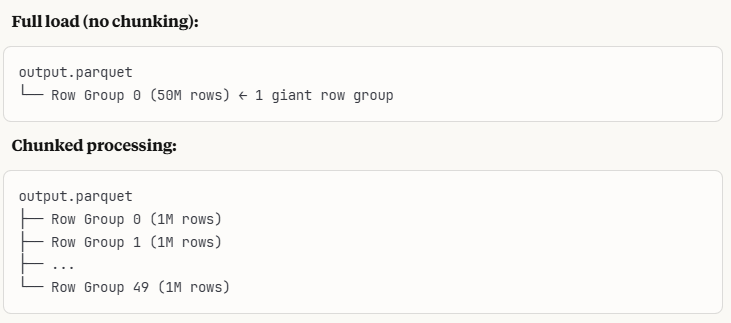

In [ ]:
import polars as pl

# Behind the scenes:
df = pl.scan_csv('file.csv.gz')  # Lazy - chưa process
# ↓
df.sink_parquet('output.parquet')  # Trigger execution
# ↓
# Stream 1: Read 64KB compressed → Decompress → Parse → Write row group 1
# Stream 2: Read 64KB compressed → Decompress → Parse → Write row group 2
# Stream N: Read 64KB compressed → Decompress → Parse → Write row group N

# Các Stream này có thể chạy song song cùng lúc (tùy thuộc vào máy có bao nhiêu core)

### **Vấn đề 3: Ưu điểm khi xử lý theo Chunking và lưu thành Parquet row group là gì?**

Nó kiểu partition để truy vấn nhanh hơn.

In [ ]:
# Nếu Parquet không chia thành các row group thì:
=> Không xử lý song song được => Chậm hơn.
=> Phải scan toàn bộ tệp .parquet.

# Query với multiple row groups (faster)
df.filter(pl.col('date') == '2024-01-01')
# → Chỉ scan relevant row groups

# Query với 1 giant row group (slower)
# → Phải scan toàn bộ row group dù chỉ cần 1 ngày


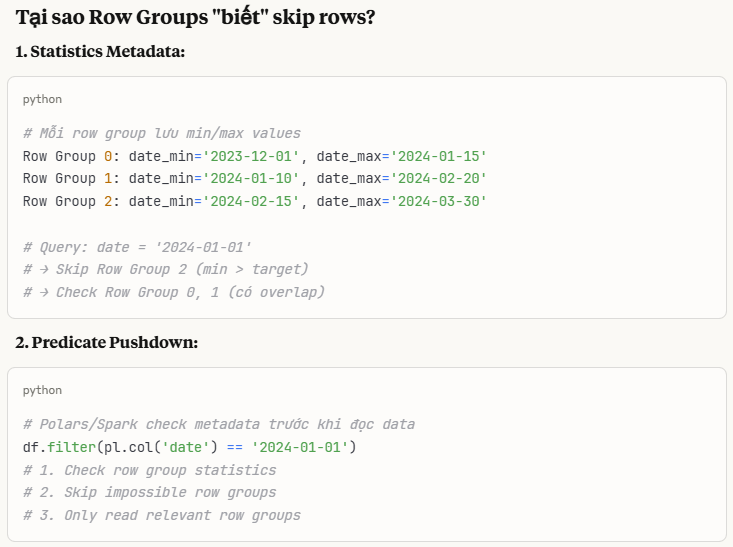

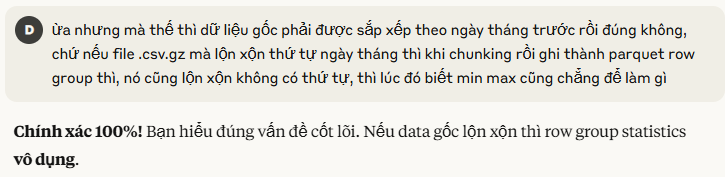

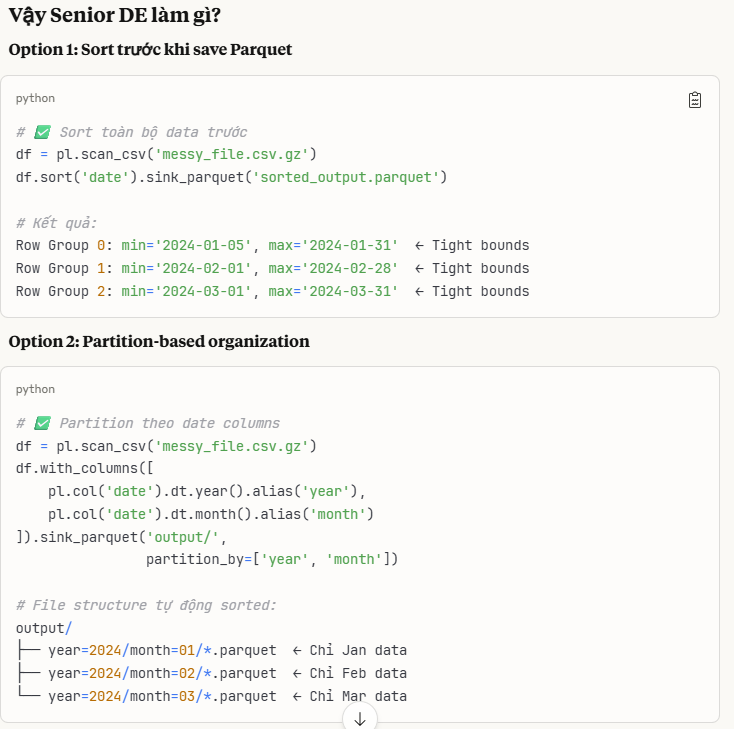

### **Vấn đề 4: Memory challenge với sorting large file.**

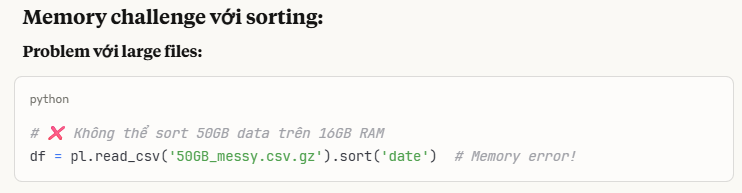

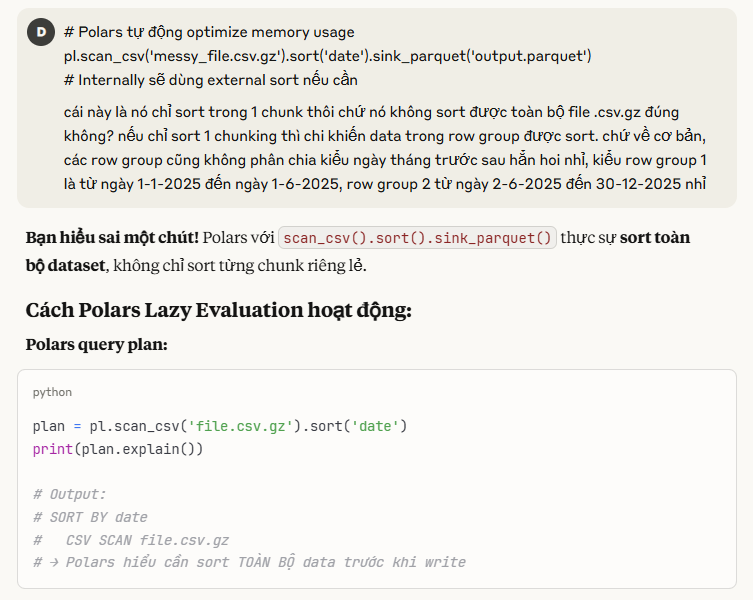

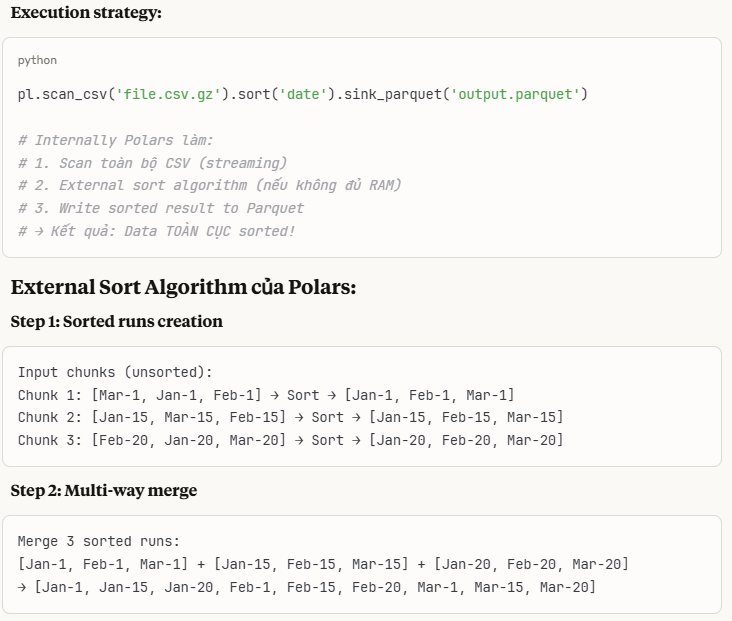